In [1]:
import torch
import triton
import triton.language as tl
from copy import deepcopy

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# 失败作品
- 这是一个失败的作品，将矩阵乘和silu融为一个算子，但是效果很差，因此最好不要把矩阵乘的操作和元素级的操作相结合
- 但是梯度之类都是对的， 仅供参考，DW还没实现

In [5]:
@triton.jit
def _fused_matmul_silu_fwd(
        # Pointers to matrices
        X, W, Y, UP, GATE, ACT,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        DTYPE: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_block_n = tl.cdiv(N, BLOCK_SIZE_N) // 2
    pid_m = pid // num_block_n
    pid_n = pid % num_block_n
    # a_ptrs += pid_m * stride_am * BLOCK_SIZE_M
    # n_offset = pid_n * stride_bn * BLOCK_SIZE_N

    x_block_ptrs = tl.make_block_ptr(
        base=X,
        shape=(M, K),
        strides=(stride_am, stride_ak),
        offsets=(pid_m * BLOCK_SIZE_M, 0),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_K),
        order=(1,0)
    )

    w_up_block_ptrs = tl.make_block_ptr(
        base=W,
        shape=(K, N),
        strides=(stride_bk, stride_bn),
        offsets=(0, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_K, BLOCK_SIZE_N),
        order=(1,0)
    )

    w_gate_block_ptrs = tl.make_block_ptr(
        base=W,
        shape=(K, N),
        strides=(stride_bk, stride_bn),
        offsets=(0, (pid_n + num_block_n)*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_K, BLOCK_SIZE_N),
        order=(1,0)
    )

    y_block_ptrs = tl.make_block_ptr(
        base=Y,
        shape=(M, N//2),
        strides=(stride_cm, stride_cn),
        offsets=(pid_m*BLOCK_SIZE_M, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )

    gate_block_ptrs = tl.make_block_ptr(
        base=GATE,
        shape=(M, N//2),
        strides=(stride_cm, stride_cn),
        offsets=(pid_m*BLOCK_SIZE_M, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )

    up_block_ptrs = tl.make_block_ptr(
        base=UP,
        shape=(M, N//2),
        strides=(stride_cm, stride_cn),
        offsets=(pid_m*BLOCK_SIZE_M, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )

    act_block_ptrs = tl.make_block_ptr(
        base=ACT,
        shape=(M, N//2),
        strides=(stride_cm, stride_cn),
        offsets=(pid_m*BLOCK_SIZE_M, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )
    
    dtype = tl.float32
    if DTYPE == 'bf16':
        dtype = tl.bfloat16
    elif DTYPE == 'fp16':
        dtype = tl.float16

    acc_up = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    acc_gate = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        x = tl.load(x_block_ptrs, boundary_check=(0,), padding_option='zero')
        w_up = tl.load(w_up_block_ptrs) # 理论上b不会溢出，相当于权重w，dim都是2的指数倍或者BLOCK_SIZE的整数倍
        w_gate = tl.load(w_gate_block_ptrs)
        # We accumulate along the K dimension.
        acc_up = tl.dot(x, w_up, acc_up)
        acc_gate = tl.dot(x, w_gate, acc_gate)
        # Advance the ptrs to the next K block.
        x_block_ptrs = tl.advance(x_block_ptrs, offsets=(0, BLOCK_SIZE_K))
        w_up_block_ptrs = tl.advance(w_up_block_ptrs, offsets=(BLOCK_SIZE_K, 0))
        w_gate_block_ptrs = tl.advance(w_gate_block_ptrs, offsets=(BLOCK_SIZE_K, 0))

    tl.store(up_block_ptrs, acc_up.to(dtype), boundary_check=(0,))
    tl.store(gate_block_ptrs, acc_gate.to(dtype), boundary_check=(0,))
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    act =  acc_gate * tl.sigmoid(acc_gate)
    y = act * acc_up
    # tl.store(up_block_ptrs, acc_up.to(dtype), boundary_check=(0,))
    # tl.store(gate_block_ptrs, acc_gate.to(dtype), boundary_check=(0,))
    tl.store(act_block_ptrs, act.to(dtype), boundary_check=(0,))
    tl.store(y_block_ptrs, y.to(dtype), boundary_check=(0,)) # M是bs * seq_len， 可能会溢出


@triton.jit
def _fused_mul_silu_bwd_dupgateact(UP, GATE, ACT, 
                               DY, DUP, DGATE,
                               stride_m, stride_n,
                               N, BLOCK_N: tl.constexpr
                               ):
    pid = tl.program_id(0)
    offset = pid * stride_m
    cols = tl.arange(0, BLOCK_N)
    ptrs = offset + cols
    mask = cols < N
    
    dy = tl.load(DY+ptrs, mask=mask, other=0.)
    dtype = dy.dtype
    dy = dy.to(tl.float32)
    act = tl.load(ACT+ptrs, mask=mask, other=0.).to(tl.float32)
    dup = act * dy
    tl.store(DUP+ptrs, dup.to(dtype), mask=mask)

    gate = tl.load(GATE+ptrs, mask=mask, other=0.).to(tl.float32)
    up = tl.load(UP+ptrs, mask=mask, other=0.).to(tl.float32)
    dact = up * dy
    gate_neg_exp = tl.exp(-gate)
    tmp = 1 + gate_neg_exp
    fenzi =  tmp + gate * gate_neg_exp
    fenmu = tmp * tmp
    dgate = (fenzi / fenmu) * dact
    tl.store(DGATE+ptrs, dgate.to(dtype), mask=mask)

@triton.jit
def _fused_mul_silu_bwd_dx(W,
                    DUP, DGATE, DX, 
                    M, K, N, 
                    stride_upm, stride_upn, 
                    stride_wk, stride_wn, 
                    stride_xm, stride_xk,
                    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_K: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, 
                    DTYPE: tl.constexpr
                    ):
    pid = tl.program_id(0)
    num_block_k = tl.cdiv(K, BLOCK_SIZE_K)
    pid_m = pid // num_block_k
    pid_k = pid % num_block_k

    dup_block_ptrs = tl.make_block_ptr(
        base=DUP,
        shape=(M, N),
        strides=(stride_upm, stride_upn),
        offsets=(pid_m * BLOCK_SIZE_M, 0),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )

    dgate_block_ptrs = tl.make_block_ptr(
        base=DGATE,
        shape=(M, N),
        strides=(stride_upm, stride_upn),
        offsets=(pid_m * BLOCK_SIZE_M, 0),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )

    w_up_block_ptrs = tl.make_block_ptr(
        base=W,
        shape=(2*N, K),
        strides=(stride_wn, stride_wk),
        offsets=(0, pid_k*BLOCK_SIZE_K),
        block_shape=(BLOCK_SIZE_N, BLOCK_SIZE_K),
        order=(0,1)
    )

    w_gate_block_ptrs = tl.make_block_ptr(
        base=W,
        shape=(2*N, K),
        strides=(stride_wn, stride_wk),
        offsets=(N, pid_k*BLOCK_SIZE_K),
        block_shape=(BLOCK_SIZE_N, BLOCK_SIZE_K),
        order=(0,1)
    )

    dx_block_ptrs = tl.make_block_ptr(
        base=DX,
        shape=(M, K),
        strides=(stride_xm, stride_xk),
        offsets=(pid_m*BLOCK_SIZE_M, pid_k*BLOCK_SIZE_K),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_K),
        order=(1,0)
    )

    dtype = tl.float32
    if DTYPE == 'bf16':
        dtype = tl.bfloat16
    elif DTYPE == 'fp16':
        dtype = tl.float16

    dx = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_K), dtype=tl.float32)
    for _ in range(0, N, BLOCK_SIZE_N):
        dup = tl.load(dup_block_ptrs, boundary_check=(1,), padding_option='zero')
        dgate = tl.load(dgate_block_ptrs, boundary_check=(1,), padding_option='zero')
        w_up = tl.load(w_up_block_ptrs)
        w_gate = tl.load(w_gate_block_ptrs)
        dx += tl.dot(dup, w_up)
        dx += tl.dot(dgate, w_gate)
        dup_block_ptrs = tl.advance(dup_block_ptrs, (0, BLOCK_SIZE_N))
        dgate_block_ptrs = tl.advance(dgate_block_ptrs, (0, BLOCK_SIZE_N))
        w_up_block_ptrs = tl.advance(w_up_block_ptrs, (BLOCK_SIZE_N, 0))
        w_gate_block_ptrs = tl.advance(w_gate_block_ptrs, (BLOCK_SIZE_N, 0))

    tl.store(dx_block_ptrs, dx.to(dtype), boundary_check=(0,))

tmp = []
class _FusedMulSiLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight):
        dtype = x.dtype
        DTYPE = 'fp32'
        if dtype == torch.float16:
            DTYPE = 'fp16'
        elif dtype == torch.bfloat16:
            DTYPE = 'bf16'   
        # Check constraints.
        input_shape = x.shape
        x = x.view(-1, input_shape[-1])
        M, K = x.shape
        K, N = weight.shape
        # Allocates output.
        y = torch.empty((M, N//2), device=x.device, dtype=dtype)
        up = torch.empty((M, N//2), device=x.device, dtype=dtype)
        gate = torch.empty((M, N//2), device=x.device, dtype=dtype)
        act = torch.empty((M, N//2), device=x.device, dtype=dtype)
        # 1D launch kernel where each block gets its own program.
        BLOCK_SIZE_M = min(64, triton.next_power_of_2(M))
        BLOCK_SIZE_N = min(64, triton.next_power_of_2(N))
        BLOCK_SIZE_K = 16
        num_warps = 4
        num_stages = 4
        grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
        _fused_matmul_silu_fwd[grid](
            x, weight, y, up, gate, act,#
            M, N, K,  #
            x.stride(0), x.stride(1),  #
            weight.stride(0), weight.stride(1),  #
            y.stride(0), y.stride(1),  #
            BLOCK_SIZE_M, BLOCK_SIZE_N, BLOCK_SIZE_K, DTYPE,
            num_warps=num_warps, num_stages=num_stages, 
        )
        ctx.save_for_backward(x, weight, up, gate, act)
        ctx.input_shape = input_shape
        ctx.DTYPE = DTYPE
        # ctx.BLOCK_SIZE = (BLOCK_SIZE_M, BLOCK_SIZE_N, BLOCK_SIZE_K)
        return y.view(*input_shape[:-1],-1)
        # return act
    
    @staticmethod
    def backward(ctx, dy):
        input_shape = ctx.input_shape
        dy = dy.view(*input_shape[:-1], -1)
        x, w, up, gate, act = ctx.saved_tensors # w.shape: [K, N]
        dup = torch.empty_like(up)
        dgate = torch.empty_like(gate)
        # 
        #  ************    first_step: compute dup dgate    ************
        M, N = dy.shape
        BLOCK_N = triton.next_power_of_2(N)
        _fused_mul_silu_bwd_dupgateact[(M,)](up, gate, act, 
                                   dy, dup, dgate,
                                   *dy.stride(),
                                   N, BLOCK_N, 
                                   num_warps=8, num_stages=4)
        dx = torch.empty_like(x)
        K = x.shape[-1]
        # print(M,N,K)
        BLOCK_SIZE_M = min(32, triton.next_power_of_2(M))
        BLOCK_SIZE_K = min(32, triton.next_power_of_2(K))
        BLOCK_SIZE_N = 32
        num_warps = 4
        num_stages = 4
        # print(dup[:3])
        # print(dgate[:3])
        # print(w.shape)
        # print(w.stride(), dup.stride(), dx.stride())
        grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(K, META['BLOCK_SIZE_K']), )
        _fused_mul_silu_bwd_dx[grid](w,
                    dup, dgate, dx,
                    M, K, N, 
                    *dup.stride(),
                    *w.stride(), 
                    *dx.stride(),
                    BLOCK_SIZE_M, BLOCK_SIZE_K, BLOCK_SIZE_N, 
                    ctx.DTYPE, 
                    num_stages=num_stages, num_warps=num_warps,
                    )
        # dx = torch.cat([dup, dgate], axis=-1) @ w.T
        return dx, None

fused_mul_silu = _FusedMulSiLU.apply

class MulSiLU(torch.nn.Module):
    def __init__(self, hidden_size, intermediate_size=None):
        super().__init__()
        if intermediate_size is None:
            intermediate_size = hidden_size * 8
        self.w = torch.nn.Linear(hidden_size, intermediate_size, bias=False)
        self.act_fn = torch.nn.SiLU()

    def forward(self, hidden_state):
        out = self.w(hidden_state)
        up, gate = out.chunk(2, -1)
        return up * self.act_fn(gate)

class TritonFusedMulSiLU(torch.nn.Module):
    def __init__(self, hidden_size, intermediate_size=None):
        super().__init__()
        if intermediate_size is None:
            intermediate_size = hidden_size * 8
        self.w = torch.nn.Linear(hidden_size, intermediate_size, bias=False)

    def forward(self, hidden_state):
        return fused_mul_silu(hidden_state, self.w.weight.T)

In [6]:
bs = 32
hidden_size = 128
dtype = torch.float32
device = 'cuda'
x1 = torch.randn(bs, hidden_size).to(device).to(dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)
dy = torch.ones(bs, hidden_size*4).to(device).to(dtype)
up = torch.zeros_like(dy)
gate = torch.zeros_like(dy)
up.requires_grad_(True)
gate.requires_grad_(True)
torch_mul_silu = MulSiLU(hidden_size).to(device).to(dtype)
y1 = torch_mul_silu(x1)
y2 = fused_mul_silu(x2, torch_mul_silu.w.weight.data.T)
print(torch.allclose(y1, y2, atol=1e-2))

True


In [ ]:
if x2.grad is not None:
    x2.grad.zero_()
if x1.grad is not None:
    x1.grad.zero_()
y1 = torch_mul_silu(x1)
_y2 = fused_mul_silu(x2, torch_mul_silu.w.weight.data.T)
y1.backward(dy)
_y2.backward(dy)

In [8]:
x1.grad

tensor([[ 0.6057, -0.8023,  0.2951,  ..., -1.0009,  0.3365, -0.4764],
        [-0.2243,  0.6240,  0.1433,  ..., -0.1300, -0.2523, -0.8741],
        [-0.5612,  0.3279, -0.0631,  ...,  0.0737,  0.6068,  1.0419],
        ...,
        [ 1.1057,  0.7209,  1.0173,  ...,  0.0222, -1.0308,  0.8422],
        [ 0.7728, -0.7765, -0.0887,  ..., -0.1251, -0.4254, -0.4571],
        [-0.1539,  0.5414, -0.2653,  ..., -0.7188, -0.0299,  0.9419]],
       device='cuda:0')

In [9]:
x2.grad

tensor([[ 0.6050, -0.8010,  0.2944,  ..., -0.9995,  0.3357, -0.4756],
        [-0.2238,  0.6233,  0.1426,  ..., -0.1295, -0.2516, -0.8726],
        [-0.5606,  0.3274, -0.0631,  ...,  0.0737,  0.6061,  1.0404],
        ...,
        [ 1.1045,  0.7201,  1.0159,  ...,  0.0227, -1.0286,  0.8411],
        [ 0.7715, -0.7755, -0.0883,  ..., -0.1245, -0.4249, -0.4564],
        [-0.1535,  0.5406, -0.2647,  ..., -0.7173, -0.0295,  0.9404]],
       device='cuda:0')

bs: 8, seq_len: 1024


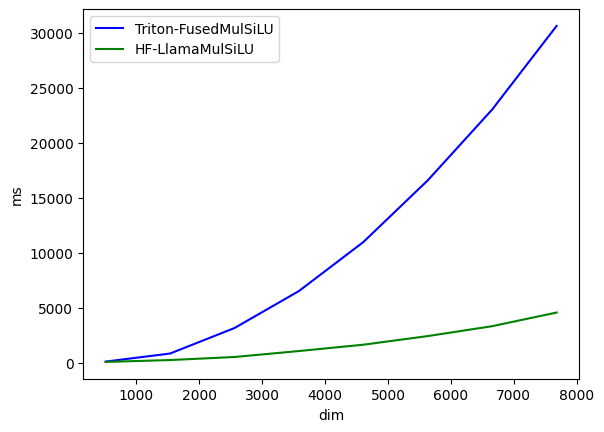

mul silu:
      dim  Triton-FusedMulSiLU  HF-LlamaMulSiLU
0   512.0            99.306673        67.722902
1  1536.0           831.676662       238.228232
2  2560.0          3152.609348       516.662121
3  3584.0          6516.749382      1057.967663
4  4608.0         10974.406242      1634.543896
5  5632.0         16589.042664      2419.462204
6  6656.0         23033.687592      3318.871021
7  7680.0         30637.748718      4561.211586


In [5]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[512 * i for i in range(1, 16+1, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-FusedMulSiLU', 'HF-LlamaMulSiLU'],  # possible values for `line_arg``
        line_names=[
            "Triton-FusedMulSiLU",
            "HF-LlamaMulSiLU",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="mul silu",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-FusedMulSiLU':
        func = TritonFusedMulSiLU(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(tensor))
    if provider == 'HF-LlamaMulSiLU':
        func = MulSiLU(dim).cuda().to(dtype)
        ms = triton.testing.do_bench(lambda: func(tensor))

    return ms * 1e3
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
